In [1]:
import hmc_tomography
from hmc_tomography.Samplers import HMC
import numpy

/home/larsgebraad/Documents/Work/Hamiltonian Monte Carlo/hmc-tomography/hmc_tomography/Distributions/__init__.py:37: UserWarning: Couldn't find the required package for ElasticFullWaveform2D. Detailed errormessage: No module named '__psvWave_cpp'
  f"Couldn't find the required package for ElasticFullWaveform2D. Detailed error"


# Tutorial 3 - Creating your own inverse problem

This notebook will show the steps required to implement (HMC) sampling of your own defined inverse problem.

To illustrate the process we will implement the Styblisnky-Tang function in arbitrary dimensions. The class will be built piece by piece, to indicate all required objects.

To implement any distribution / likelihood / target, we need to inherit from `hmc_tomography.Distributions._AbstractDistribution`. By doing this, we can make the sampler understand that we passed a distribution, as well as providing checks on all required methods and attributes.

<div class="alert alert-info">    
<b>**Note:**</b> We will now go through the process of illustrating what happens when you implement a distribution yourself, in steps. I'll do this in a trial-and-error fashion, to show what happens if you omit required parts. For the shorter technical version, I refer to the documentation of the abstract class <span style="display:none">[hmc_tomography.Distributions._AbstractDistribution](../api/distributions/_AbstractDistribution.rst)</span>, which illustrates the required abstract methods and attributes.
</div>

## Gathering all the ingredients

We can create a class that defines nothing (yet) and only inherits from the abstract base class the following way:

In [2]:
class my_inverse_problem_class(hmc_tomography.Distributions._AbstractDistribution):
    pass

We now have a class of this distribution, e.g. a template on how to construct it. To actually use it, we need an instance. Instances of classes are created in the following way:

In [3]:
try:
    target = my_inverse_problem_class()
except Exception as e:
    print(e)

Can't instantiate abstract class my_inverse_problem_class with abstract methods gradient, misfit


Oops, that didn't work! If we try to decipher the Python error we can actually understand why: the class is missing 'abstract' functions. **Abstract functions are functions that we have to implement ourselves.** The abstract base class is asking for the following functions:

1. `generate` : A function that generates an independent sample from the distrbution (i.e. subsequent samples are i.i.d.).
2. `gradient` : A function to compute the gradient of the misfit function.
3. `misfit`   : A function to compute the misfit function.

Typically, we can not generate from a distribution that we still wish to investigate. But not to worry, if we actually inspect the documentation of these functions we can see that we do not require the `generate` function to work in order to sample using Markov chain Monte Carlo methods:

In [4]:
print(
    f"Function: {hmc_tomography.Distributions._AbstractDistribution.generate.__name__}"
)
print(hmc_tomography.Distributions._AbstractDistribution.generate.__doc__)

Function: generate
Method to draw samples from the distribution.

        Returns
        -------
        sample : numpy.ndarray
            A numpy array shaped as (dimensions, 1) containing a sample of the
            distribution.

        Raises
        ------
        NotImplementedError
            If the distribution does not allow generation of samples.


        This method is mostly a convenience class. The algorithm itself does not
        require the implementation. Therefore an implementation as such will suffice::

            def generate(self) -> _numpy.ndarray:
                raise NotImplementedError("This function is not implemented.")

        


<span style="display:none">The API reference of this method can be found at&#32;[_AbstractDistribution.generate](../api/distributions/_AbstractDistribution.rst#hmc_tomography.Distributions._AbstractDistribution.generate).</span>

The required input of `misfit` and `gradient` is a numpy vector of shape (dimensions, 1). The outputs are respectively a float and a numpy vector of shape (dimensions, 1). This can also be found when printing the documentation:

In [5]:
print(
    f"Function: {hmc_tomography.Distributions._AbstractDistribution.gradient.__name__}"
)
print(hmc_tomography.Distributions._AbstractDistribution.gradient.__doc__)

print(f"Function: {hmc_tomography.Distributions._AbstractDistribution.misfit.__name__}")
print(hmc_tomography.Distributions._AbstractDistribution.misfit.__doc__)

Function: gradient
Computes the misfit gradient of the distribution at the given coordinates.

        Parameters
        ----------
        coordinates : numpy.ndarray
            Numpy array shaped as (dimensions, 1) representing a column vector
            containing the coordinates :math:`\mathbf{m}`.

        Returns
        -------
        gradient : numpy.ndarray
            The distribution misfit gradient :math:`\nabla_\mathbf{m}\chi`.


        The distribution misfit gradient is related to the distribution probability
        density as:

        .. math::

            \nabla_\mathbf{m} \chi_\text{distribution} (\mathbf{m}) = -
            \nabla_\mathbf{m} \log p(\mathbf{m}).


        This method is called many times in an HMC appraisal. It is therefore
        beneficial to optimize the implementation.
        
Function: misfit
Computes the misfit of the distribution at the given coordinates.

        Parameters
        ----------
        coordinates : numpy.ndarray
     

<span style="display:none">The API reference of these methods can be found at&#32;[_AbstractDistribution.gradient](../api/distributions/_AbstractDistribution.rst#hmc_tomography.Distributions._AbstractDistribution.gradient)&#32;and&#32;[_AbstractDistribution.misfit](../api/distributions/_AbstractDistribution.rst#hmc_tomography.Distributions._AbstractDistribution.misfit).</span>

## An empty target model: Brownian Motion

To start, we can make a mock class, with zero misfit everywhere. This was the easiest implementation of *a* distribution that I could think of.

This essentially is a uniform unbouded distribution. Because it is an unnormalizable distribution, it is actually an improper prior. However, that doesn't stop us from creating a Markov chain over it.

A class based on this could look like the following:

In [6]:
class my_inverse_problem_class(hmc_tomography.Distributions._AbstractDistribution):
    def misfit(self, m):
        return 0

    def gradient(self, m):
        return numpy.zeros((dimensions, 1))

    def generate(self, m):
        raise NotImplementedError()

Creating an instance of this class should work now we have implemented all the required functions:

In [7]:
try:
    target = my_inverse_problem_class()
except Exception as e:
    print(e)

Can't instantiate abstract class my_inverse_problem_class with abstract attributes: dimensions


**The error changed!** No complaints about missing methods. We now have a complaint about a missing attribute; `dimensions`. It turns out, to do any sampling, we still have to define in what dimension model space we are operating. We can set this property in the constructor in the following way:

In [8]:
class my_inverse_problem_class(hmc_tomography.Distributions._AbstractDistribution):
    def __init__(self):
        self.dimensions = 2

    def misfit(self, m):
        return 0

    def gradient(self, m):
        return numpy.zeros((self.dimensions, 1))

    def generate(self, m):
        raise NotImplementedError()

In [9]:
try:
    target = my_inverse_problem_class()
except Exception as e:
    print(e)

**No errors!!**

Now that we have an instance of a distribution, we can supply it to a sampler. Let's give Hamiltonian Monte Carlo a try. The only thing we need other than the target is a mass matrix and a sampler instance. Creating these and starting the sampler:

In [10]:
HMC().sample(
    "bin/3/empty_distribution.h5",
    target,
    proposals=3000,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (bin/3/empty_distribution.h5) if it exists.


Tot. acc rate: 0.00. Progress:   0%|          | 0/3000 [00:00<?, ?it/s]

Visualizing the results shows how this empty class creates a Brownian motion. Brownian motion is simply a process that is independent of starting point and scale. Go ahead and change the time step of HMC or the amount of steps, histograms will always look similar (similarly random).

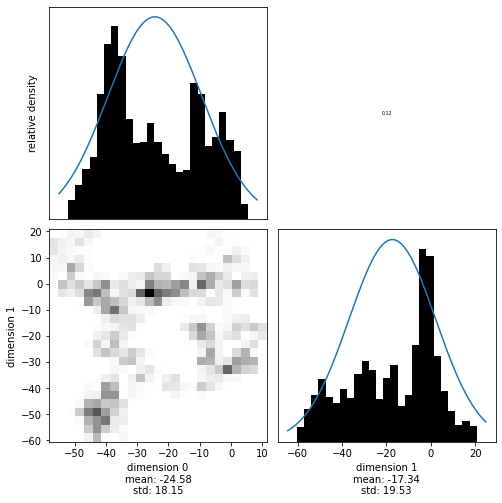

In [11]:
with hmc_tomography.Samples("bin/3/empty_distribution.h5") as samples:
    hmc_tomography.Visualization.marginal_grid(samples, [0, 1])

## The Styblinsky-Tang Function

A more complete example would be to inplement some function as misfit and its derivative. One thing the following class implements is tempering, i.e. annealing. This changes a distribution to amplify or surpress local minima. This is a technique used in algorithms such as [parallel tempering](https://en.wikipedia.org/wiki/Parallel_tempering) and [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing). Tempering is implemented simply by dividing the misfit (and gradient) by the temperature. 

You're completely free to do the implementation of the gradient in any way you want (analytical derivatives, backpropagation, finite differences), however the accuracy to which the gradient is computed has direct influence on the performance of HMC. Getting it right (and fast) is typically essential to performant sampling with HMC.

The example demonstrated here is the n-dimensional tempered Styblinsky-Tang function. Its misfit is a sum of the same expression on every separate dimension, making the expression of the misfit and gradient rather simple. We don't implement a generate function (as I wouldn't know an effective way of generating samples), and we leave the dimensionality open to each instance.

In [12]:
class StyblinskiTang(hmc_tomography.Distributions._AbstractDistribution):
    def __init__(self, dimensions=None, temperature=20.0):

        # Default to 2 dimensions if not specified
        if dimensions is None:
            self.dimensions = 2
        else:
            self.dimensions = dimensions

        # Default to temperature = 10 if not specified
        self.temperature = temperature

    def misfit(self, m):

        # Check the shape of the passed model
        assert m.shape == (self.dimensions, 1)

        return 0.5 * numpy.sum(m ** 4 - 16 * (m ** 2) + 5 * m) / self.temperature

    def gradient(self, m):

        assert m.shape == (self.dimensions, 1)

        return 0.5 * (4 * (m ** 3) - 32 * m + 5) / self.temperature

    def generate(self, m):
        raise NotImplementedError()

No errors is always good. Let's try sampling this distribution at a temperature of 20.

In [13]:
target = StyblinskiTang(temperature=20)

HMC().sample(
    "bin/3/styblinski-tang.h5",
    target,
    proposals=20000,
    stepsize=1.0,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (bin/3/styblinski-tang.h5) if it exists.


Tot. acc rate: 0.00. Progress:   0%|          | 0/20000 [00:00<?, ?it/s]

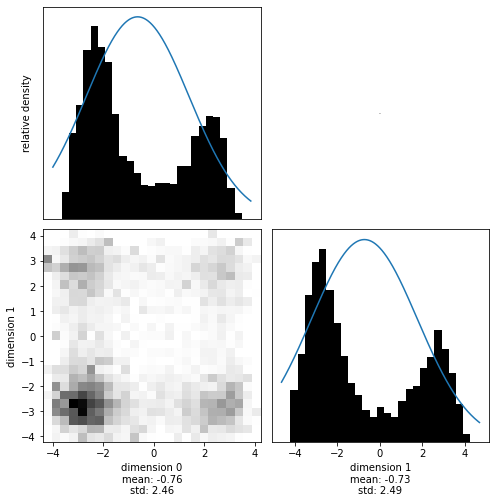

In [14]:
with hmc_tomography.Samples("bin/3/styblinski-tang.h5") as samples:
    hmc_tomography.Visualization.marginal_grid(samples, [0, 1], bins=25)

That looks great! Now you are ready to use the package on **your** interesting problems. Have fun!

As a bonus, we can check what influence the tempering parameter has on the shape of the probability distribution. Reducing the temperature to 5 will 'cool' the distribution, sharpening it:

In [15]:
target = StyblinskiTang(temperature=5)

HMC().sample(
    "bin/3/styblinski-tang_cool.h5",
    target,
    proposals=20000,
    stepsize=0.5,
    overwrite_existing_file=True,
)

sys:1: Warning: 
Silently overwriting samples file (bin/3/styblinski-tang_cool.h5) if it exists.


Tot. acc rate: 0.00. Progress:   0%|          | 0/20000 [00:00<?, ?it/s]

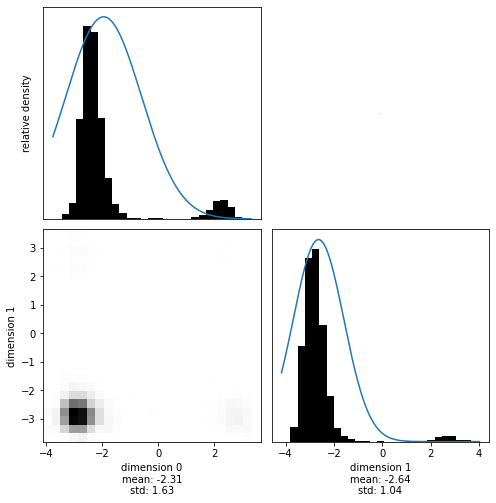

In [16]:
with hmc_tomography.Samples("bin/3/styblinski-tang_cool.h5") as samples:
    hmc_tomography.Visualization.marginal_grid(samples, [0, 1], bins=25)